In [41]:
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition, manifold
import statsmodels.api as sm
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh.utilities.dataframe_functions import impute

## 1. 

In [3]:
pbs_df = pd.read_csv("data/tsibbledata/PBS.csv")
pbs_df.Month.replace({'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}, regex=True, inplace=True)
pbs_df.Month = pd.to_datetime(pbs_df.Month, format="%Y %b")

In [30]:
pbs_aggs = (pbs_df.groupby(by=["Concession", "Type", "ATC1", "ATC2"], as_index=False)
                  .agg(Mean_Script=("Scripts", "mean"), 
                       Std_Script=("Scripts", "std"), 
                       Mean_Cost=("Cost", "mean"), 
                       Std_Cost=("Cost", "std")))

In [42]:
pbs_max_mean = pbs_aggs.sort_values(by="Mean_Cost", ascending=False).iloc[0]
pbs_min_std = pbs_aggs.sort_values(by="Std_Cost").iloc[0]

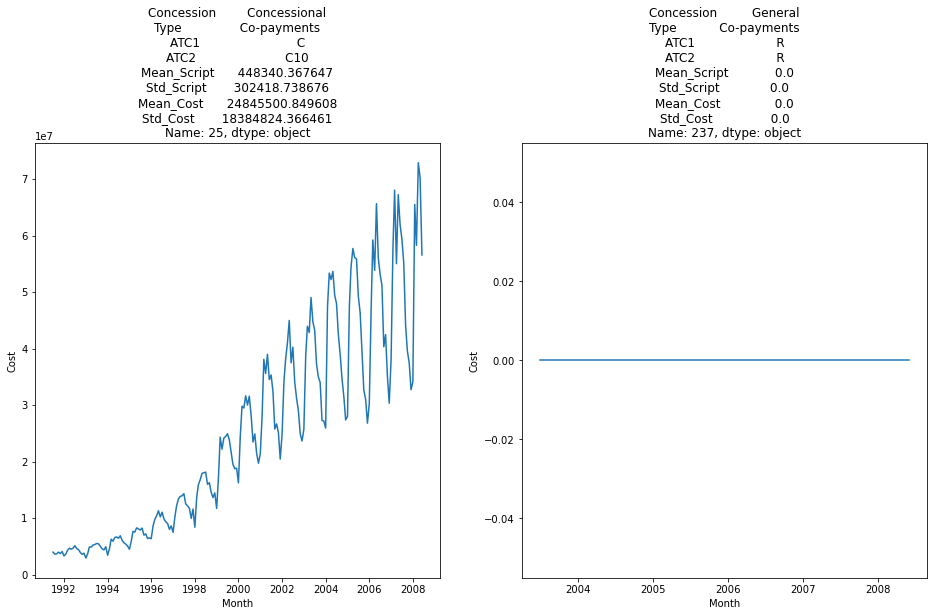

In [50]:
max_mean_ts = pbs_df.query("Concession == @pbs_max_mean.Concession and Type == @pbs_max_mean.Type and ATC1 == @pbs_max_mean.ATC1 and ATC2 == @pbs_max_mean.ATC2")
min_std_ts = pbs_df.query("Concession == @pbs_min_std.Concession and Type == @pbs_min_std.Type and ATC1 == @pbs_min_std.ATC1 and ATC2 == @pbs_min_std.ATC2")

fig, axs = plt.subplots(ncols=2, figsize=(16, 8))

sns.lineplot(data=max_mean_ts, x="Month", y="Cost", ax = axs[0]).set(title=f"{pbs_max_mean}")
sns.lineplot(data=min_std_ts, x="Month", y="Cost", ax = axs[1]).set(title=f"{pbs_min_std}");

## 2. 

In [78]:
tourism = pd.read_csv("data/tsibble/tourism.csv")
tourism["Quarter"] = pd.DatetimeIndex(tourism.Quarter.replace({" ": "-"}, regex=True))
groups = tourism.groupby(by=["Region", "State", "Purpose"])

In [120]:
qtr_data = []
for ky, grp in groups:
    grp_fit = sm.tsa.STL(grp.Trips, seasonal=9, period=4).fit()
    grp["seasonal"] = grp_fit.seasonal
    grp["Qtr"] = grp.Quarter.dt.quarter
    grp["State"] = ky[1]
    gdata = grp.groupby(by=["State", "Qtr"], as_index=False).agg(Avg_Trips=("Trips", "mean"), Avg_Seasonal=("seasonal", "mean"))
    qtr_data.append(gdata)

In [138]:
dd = pd.concat(qtr_data)
dd.groupby(by=["State", "Qtr"]).mean().groupby(level=0).agg(["idxmax", "idxmin"])

Avg_Trips                           \
                                     idxmax                   idxmin   
State                                                                  
ACT                                (ACT, 2)                 (ACT, 1)   
New South Wales        (New South Wales, 1)     (New South Wales, 3)   
Northern Territory  (Northern Territory, 3)  (Northern Territory, 1)   
Queensland                  (Queensland, 3)          (Queensland, 1)   
South Australia        (South Australia, 1)     (South Australia, 3)   
Tasmania                      (Tasmania, 1)            (Tasmania, 3)   
Victoria                      (Victoria, 1)            (Victoria, 3)   
Western Australia    (Western Australia, 1)   (Western Australia, 3)   

                               Avg_Seasonal                           
                                     idxmax                   idxmin  
State                                                                 
ACT                                (ACT, 2)                 (ACT, 1)  
New South Wales        (New South Wales, 1)     (New South Wales, 3)  
Northern Territory  (Northern Territory, 3)  (Northern Territory, 1)  
Queensland                  (Queensland, 3)          (Queensland, 1)  
South Australia        (South Australia, 1)     (South Australia, 3)  
Tasmania                      (Tasmania, 1)            (Tasmania, 3)  
Victoria                      (Victoria, 1)            (Victoria, 3)  
Western Australia    (Western Australia, 1)   (Western Australia, 3)

## 3. 

In [9]:
ids = list(zip(pbs_df.Concession, pbs_df.Type, pbs_df.ATC1, pbs_df.ATC2))
pbs_data = pd.DataFrame({"IDs": ids, "Month": pbs_df.Month, "Cost": pbs_df.Cost})

In [38]:
pbs_feats = extract_features(pbs_data, column_id="IDs", column_sort="Month")

Feature Extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.50s/it]


In [39]:
pbs_feats.drop(columns=pbs_feats.columns[pbs_feats.isna().all()], inplace=True)
impute(pbs_feats)
pbs_feats.index = pbs_feats.index.set_names(["Concession", "Type", "ATC1", "ATC2"])

In [44]:
pbs_feats_scaled = preprocessing.StandardScaler().fit_transform(pbs_feats)
pbs_pca = decomposition.PCA().fit_transform(pbs_feats_scaled)

In [55]:
pbs_feats.reset_index(inplace=True)
pbs_pca_data = (
                pd.DataFrame(pbs_pca)
                  .assign(Concession = pbs_feats.Concession, 
                          Type = pbs_feats.Type,
                          ATC1 = pbs_feats.ATC1,
                          ATC2 = pbs_feats.ATC2
                         )
)

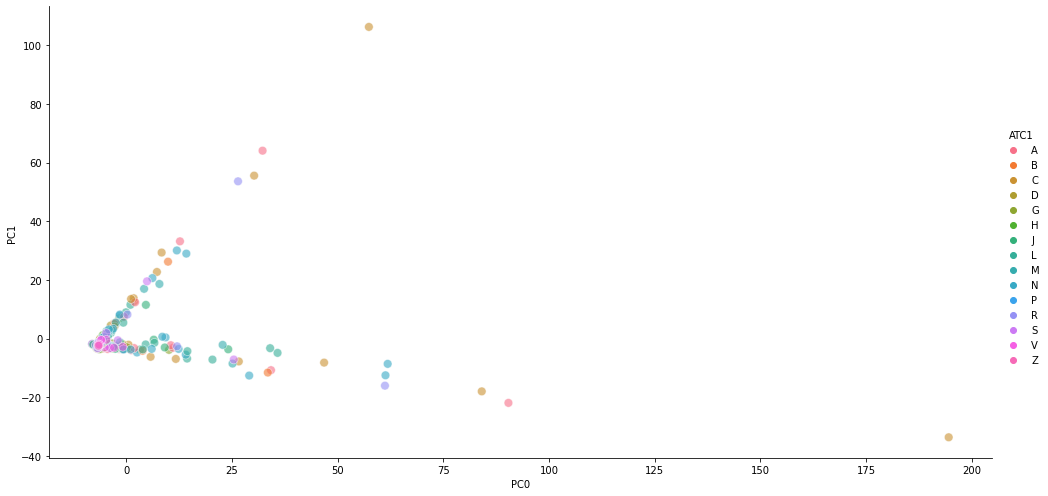

In [89]:
names = []
for col in pbs_pca_data.columns:
    if isinstance(col, int):
        col = f"PC{col}"
    names.append(col)

pbs_pca_data.columns = names
sns.relplot(data=pbs_pca_data, x="PC0", y="PC1", hue="ATC1", height=7, aspect=2, alpha=.6, s=75);

In [83]:
pbs_pca_data.loc[pbs_pca_data.PC0 > 50, ["Concession", "Type", "ATC1", "ATC2"]]

,Concession,Type,ATC1,ATC2
1,Concessional,Co-payments,A,A02
24,Concessional,Co-payments,C,C09
25,Concessional,Co-payments,C,C10
63,Concessional,Co-payments,N,N05
64,Concessional,Co-payments,N,N06
71,Concessional,Co-payments,R,R03
109,Concessional,Safety net,C,C10
